# Stock Price Forecasting
This notebook demonstrates forecasting stock prices using ARIMA, SARIMA, Prophet, and LSTM models.

[*********************100%***********************]  1 of 1 completed


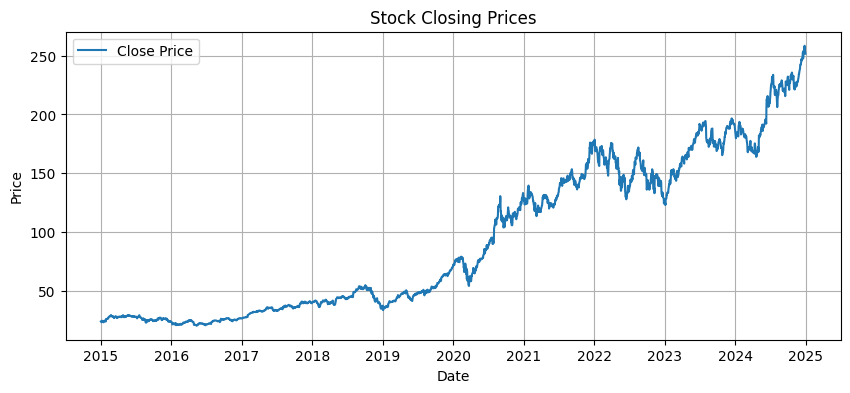

17:23:01 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0201
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8110e-04
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8437e-04
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8828e-04
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.5949e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📊 MODEL EVALUATION RESULTS
ARIMA    → RMSE: 69.62, MAE: 63.64
SARIMA   → RMSE: 55.16, MAE: 50.54
Prophet  → RMSE: 38.77, MAE: 31.86
LSTM     → RMSE: 10.99, MAE: 9.01


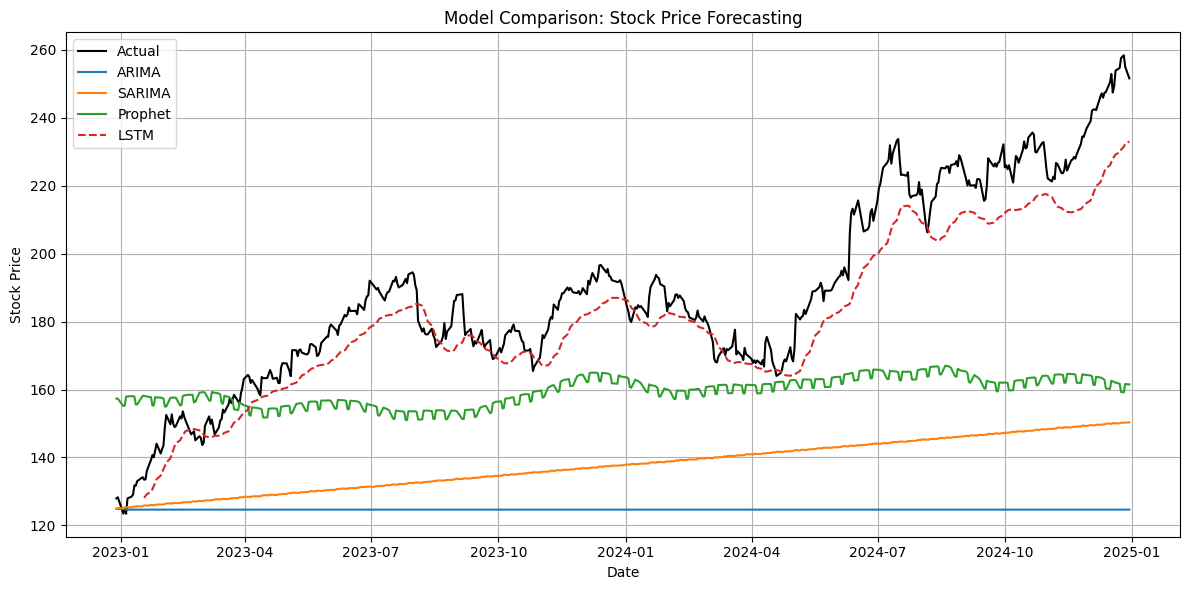

In [34]:
# 📦 Step 1: Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# 📊 Step 2: Load Data
def load_stock_data(ticker="AAPL", start="2015-01-01", end="2024-12-31"):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].dropna()
    return df

df = load_stock_data()

# 📈 Step 3: Visualization
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title("Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

# ⚙️ Step 4: Evaluation Metrics
def evaluate(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# 🧪 Step 5: Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# 📉 ARIMA Model
def arima_forecast(train, test):
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

arima_pred = arima_forecast(train, test)
arima_rmse, arima_mae = evaluate(test['Close'], arima_pred)

# 🔁 SARIMA Model
def sarima_forecast(train, test):
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

sarima_pred = sarima_forecast(train, test)
sarima_rmse, sarima_mae = evaluate(test['Close'], sarima_pred)

# 🔮 Prophet Model
def prophet_forecast(df, steps):
    # Ensure the input has a 'Close' column and a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")

    if 'Close' not in df.columns:
        raise ValueError("DataFrame must contain a 'Close' column")

    # Create a Prophet-compatible DataFrame
    df_prophet = pd.DataFrame({
        'ds': df.index,
        'y': df['Close'].values.reshape(-1)

    })

    # Drop any NaNs
    df_prophet.dropna(subset=['y'], inplace=True)

    # Fit Prophet
    model = Prophet()
    model.fit(df_prophet)

    # Forecast
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)

    return forecast['yhat'][-steps:].values



prophet_pred = prophet_forecast(train, len(test))
prophet_rmse, prophet_mae = evaluate(test['Close'], prophet_pred)



# 🧠 LSTM Model
def lstm_forecast(df, steps):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

    pred_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(pred_scaled)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    return predictions.flatten(), actual.flatten()

lstm_pred, lstm_actual = lstm_forecast(df, len(test))
lstm_rmse, lstm_mae = evaluate(lstm_actual, lstm_pred)

# 📊 Summary
print("\n📊 MODEL EVALUATION RESULTS")
print(f"ARIMA    → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"SARIMA   → RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet  → RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")
print(f"LSTM     → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

# 📉 Plot Forecasts
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA')
plt.plot(test.index, sarima_pred, label='SARIMA')
plt.plot(test.index, prophet_pred, label='Prophet')
plt.plot(test.index[-len(lstm_pred):], lstm_pred, label='LSTM', linestyle='--')
plt.title("Model Comparison: Stock Price Forecasting")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Evaluation function
def evaluate(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    return rmse, mae

# Load AAPL data for the last 3 years
end_date = datetime.today()
start_date = end_date - timedelta(days=3*365)

df = yf.download('AAPL', start=start_date, end=end_date)
df.dropna(inplace=True)

# Split into train and test (80-20 split)
def train_test_split(df, field):
    train_size = int(len(df) * 0.8)
    train = df[field][:train_size]
    test = df[field][train_size:]
    return train, test

# Prophet Forecast
def prophet_forecast(train, steps):
    df_prophet = pd.DataFrame({
        'ds': train.index,
        'y': train.values
    })
    model = Prophet()
    model.fit(df_prophet)
    
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)
    return forecast['yhat'][-steps:].values

# LSTM Forecast
def lstm_forecast(train, steps):
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(np.array(train).reshape(-1, 1))

    X, y = [], []
    for i in range(60, len(scaled_train)):
        X.append(scaled_train[i-60:i])
        y.append(scaled_train[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)

    inputs = scaled_train[-60:].reshape(1, -1)
    inputs = inputs[0].tolist()
    predictions = []

    for _ in range(steps):
        x_input = np.array(inputs[-60:]).reshape(1, 60, 1)
        pred = model.predict(x_input, verbose=0)
        inputs.append(pred[0][0])
        predictions.append(pred[0][0])
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# ARIMA Forecast
def arima_forecast(train, steps):
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps)
    return forecast.values

# SARIMA Forecast
def sarima_forecast(train, steps):
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps)
    return forecast.values

# Run forecasts on each field
fields = ['Open', 'High', 'Low', 'Close', 'Volume']
results = []

for field in fields:
    print(f"\n📈 Forecasting ({field}, AAPL)...")
    train, test = train_test_split(df, field)

    try:
        arima_pred = arima_forecast(train, len(test))
        arima_rmse, arima_mae = evaluate(test, arima_pred)
    except Exception as e:
        print(f"⚠️ ARIMA Error on {field}: {e}")
        arima_rmse = arima_mae = np.nan

    try:
        sarima_pred = sarima_forecast(train, len(test))
        sarima_rmse, sarima_mae = evaluate(test, sarima_pred)
    except Exception as e:
        print(f"⚠️ SARIMA Error on {field}: {e}")
        sarima_rmse = sarima_mae = np.nan

    try:
        prophet_pred = prophet_forecast(train, len(test))
        prophet_rmse, prophet_mae = evaluate(test, prophet_pred)
    except Exception as e:
        print(f"⚠️ Prophet Error on {field}: {e}")
        prophet_rmse = prophet_mae = np.nan

    try:
        lstm_pred = lstm_forecast(train, len(test))
        lstm_rmse, lstm_mae = evaluate(test, lstm_pred)
    except Exception as e:
        print(f"⚠️ LSTM Error on {field}: {e}")
        lstm_rmse = lstm_mae = np.nan

    results.append({
        'Field': field,
        'ARIMA_RMSE': arima_rmse,
        'ARIMA_MAE': arima_mae,
        'SARIMA_RMSE': sarima_rmse,
        'SARIMA_MAE': sarima_mae,
        'Prophet_RMSE': prophet_rmse,
        'Prophet_MAE': prophet_mae,
        'LSTM_RMSE': lstm_rmse,
        'LSTM_MAE': lstm_mae
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)
print("\n📊 Evaluation Summary:")
print(results_df)

# Save to CSV
results_df.to_csv("forecasting_results.csv", index=False)


[*********************100%***********************]  1 of 1 completed



📈 Forecasting ('Open', 'AAPL')...
⚠️ Error forecasting ('Open', 'AAPL'): got an unexpected keyword argument 'squared'

📈 Forecasting ('High', 'AAPL')...
⚠️ Error forecasting ('High', 'AAPL'): got an unexpected keyword argument 'squared'

📈 Forecasting ('Low', 'AAPL')...
⚠️ Error forecasting ('Low', 'AAPL'): got an unexpected keyword argument 'squared'

📈 Forecasting ('Close', 'AAPL')...
⚠️ Error forecasting ('Close', 'AAPL'): got an unexpected keyword argument 'squared'

📈 Forecasting ('Volume', 'AAPL')...
⚠️ Error forecasting ('Volume', 'AAPL'): got an unexpected keyword argument 'squared'

📊 Evaluation Summary:
Empty DataFrame
Columns: []
Index: []


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

## 1. Fetch Historical Stock Data

In [13]:
def fetch_data(ticker, start='2015-01-01', end=None):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].reset_index()
    return df

aapl = fetch_data('AAPL')
msft = fetch_data('MSFT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2. Preprocess the Data

In [14]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.asfreq('B')
    df['Close'] = df['Close'].interpolate()
    return df

aapl = preprocess(aapl)
msft = preprocess(msft)

## 3. Visualize Trends and Rolling Averages

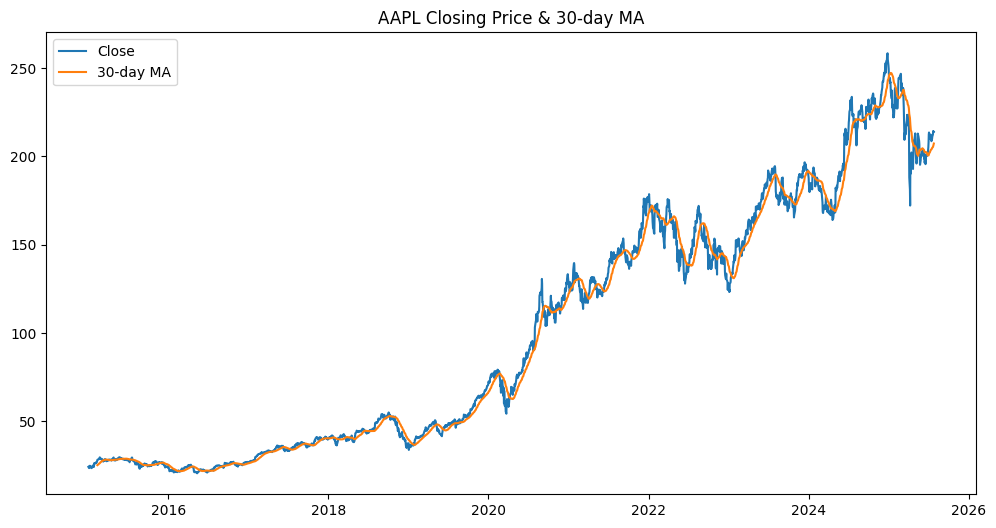

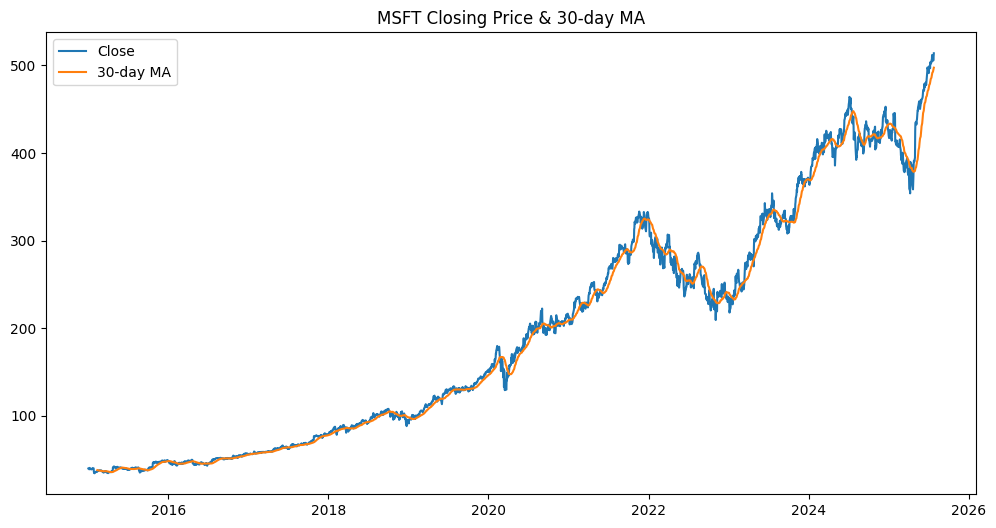

In [15]:
def plot_trends(df, title):
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'], label='Close')
    plt.plot(df['Close'].rolling(30).mean(), label='30-day MA')
    plt.title(title)
    plt.legend()
    plt.show()

plot_trends(aapl, 'AAPL Closing Price & 30-day MA')
plot_trends(msft, 'MSFT Closing Price & 30-day MA')

## 4. ARIMA and SARIMA Models

In [16]:
def arima_forecast(df, order=(5,1,0), steps=30):
    model = ARIMA(df['Close'], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast, model_fit

def sarima_forecast(df, order=(1,1,1), seasonal_order=(1,1,1,12), steps=30):
    model = SARIMAX(df['Close'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast, model_fit

## 5. Prophet Model

In [17]:
from prophet import Prophet
import pandas as pd

def prophet_forecast(df, steps=30):
    # Reset index to make datetime a column
    df_reset = df.reset_index()

    # Identify datetime column (first column after reset)
    date_col = df_reset.columns[0]

    # Ensure 'Close' is in columns after reset
    if 'Close' not in df_reset.columns:
        raise ValueError("Expected 'Close' column not found in DataFrame.")

    # Select datetime and 'Close', then rename for Prophet
    print(df_reset.columns)

    df_prophet = df_reset[[date_col, 'Close']].copy()
    df_prophet.rename(columns={date_col: 'ds', 'Close': 'y'}, inplace=True)

    # Clean and convert types
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
    df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
    df_prophet.dropna(subset=['ds', 'y'], inplace=True)

    # Train Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)

    # Forecast future
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)

    # Return only the future prediction
    forecast_future = forecast[['ds', 'yhat']].tail(steps)
    return forecast_future, model


## 6. LSTM Model

In [18]:
def lstm_forecast(df, steps=30, look_back=60):
    data = df['Close'].values.reshape(-1,1)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(look_back, len(data_scaled)-steps):
        X.append(data_scaled[i-look_back:i, 0])
        y.append(data_scaled[i:i+steps, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(steps))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)
    last_seq = data_scaled[-look_back:].reshape((1, look_back, 1))
    pred_scaled = model.predict(last_seq)[0]
    pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
    return pred, model

## 7. Model Evaluation, Saving Results, and Plotting

In [19]:
def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return rmse, mae

def save_results(results, filename):
    pd.DataFrame(results).to_csv(filename, index=False)

def plot_predictions(true, pred, title):
    plt.figure(figsize=(10,5))
    plt.plot(true, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

## 8. Run All Models, Compare, Save Results, and Plot for AAPL

Index(['Date', 'Close'], dtype='object')


17:10:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:24 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


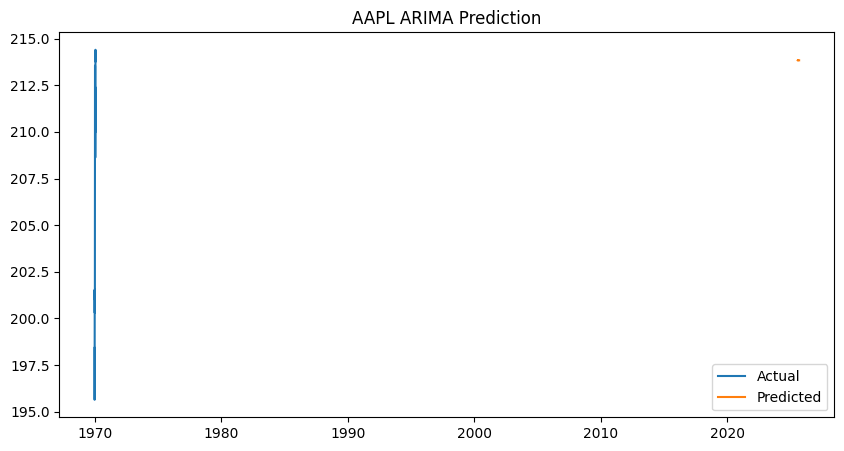

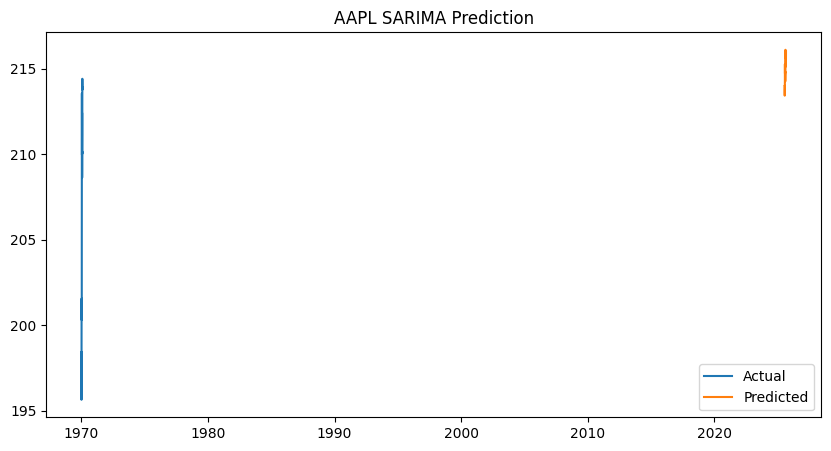

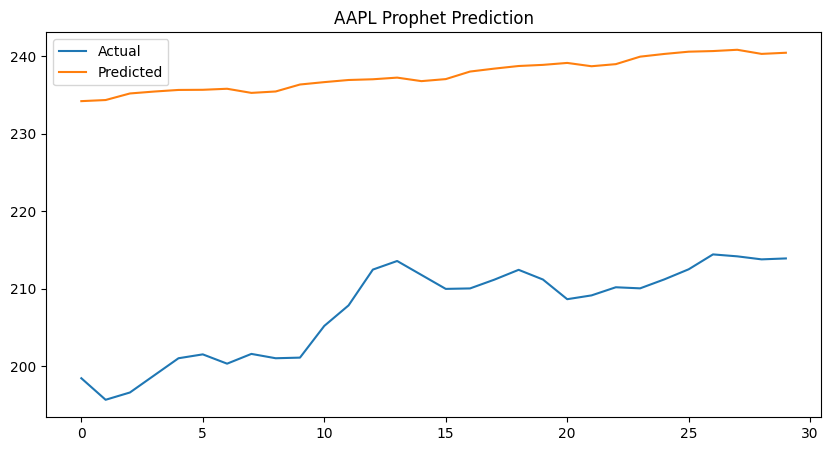

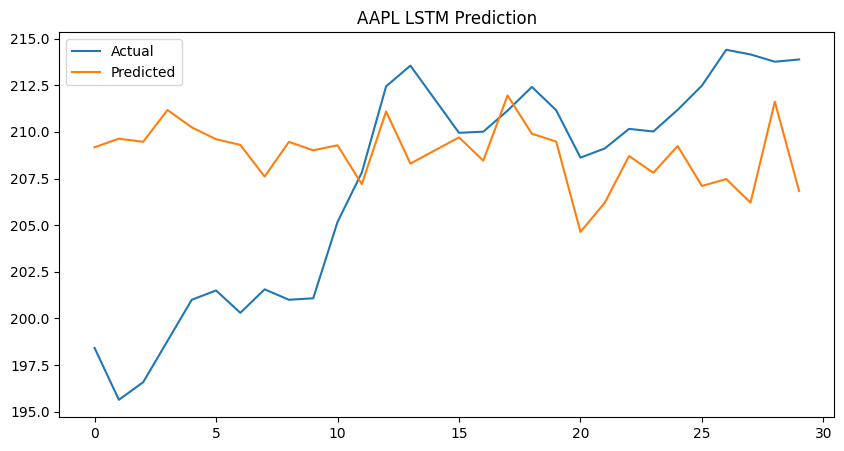

In [20]:
import numpy as np
import pandas as pd

# 🧹 Step 1: Flatten MultiIndex and Extract 'Close' for 'AAPL'
# Assumes 'aapl' was loaded with yfinance and has MultiIndex columns
aapl_close = aapl[('Close', 'AAPL')].copy()
aapl_close.name = 'Close'
aapl = aapl_close.to_frame()

# 🧼 Step 2: Drop any NaN values from 'Close'
aapl.dropna(subset=['Close'], inplace=True)

# 📊 Step 3: Get actual values for the last 30 days
steps = 30
actual = aapl['Close'][-steps:].values

# 📈 Step 4: Run Forecasts
arima_pred, _ = arima_forecast(aapl, steps=steps)
sarima_pred, _ = sarima_forecast(aapl, steps=steps)
prophet_pred, _ = prophet_forecast(aapl, steps=steps)
lstm_pred, _ = lstm_forecast(aapl, steps=steps)

# 📏 Step 5: Evaluate Models
arima_rmse, arima_mae = evaluate(actual, np.array(arima_pred))
sarima_rmse, sarima_mae = evaluate(actual, np.array(sarima_pred))
prophet_vals = prophet_pred['yhat'].values
prophet_rmse, prophet_mae = evaluate(actual, prophet_vals)
lstm_rmse, lstm_mae = evaluate(actual, np.array(lstm_pred))

# 📝 Step 6: Save Evaluation Results
results = [
    {'Model': 'ARIMA', 'RMSE': arima_rmse, 'MAE': arima_mae},
    {'Model': 'SARIMA', 'RMSE': sarima_rmse, 'MAE': sarima_mae},
    {'Model': 'Prophet', 'RMSE': prophet_rmse, 'MAE': prophet_mae},
    {'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAE': lstm_mae}
]
save_results(results, 'aapl_model_results.csv')

# 📊 Step 7: Plot Predictions
plot_predictions(actual, arima_pred, 'AAPL ARIMA Prediction')
plot_predictions(actual, sarima_pred, 'AAPL SARIMA Prediction')
plot_predictions(actual, prophet_vals, 'AAPL Prophet Prediction')
plot_predictions(actual, lstm_pred, 'AAPL LSTM Prediction')


## 9. Run All Models, Compare, Save Results, and Plot for MSFT

In [21]:
steps = 30
actual = msft['Close'][-steps:].values
arima_pred, _ = arima_forecast(msft, steps=steps)
sarima_pred, _ = sarima_forecast(msft, steps=steps)
prophet_pred, _ = prophet_forecast(msft, steps=steps)
lstm_pred, _ = lstm_forecast(msft, steps=steps)

arima_rmse, arima_mae = evaluate(actual, np.array(arima_pred))
sarima_rmse, sarima_mae = evaluate(actual, np.array(sarima_pred))
prophet_vals = prophet_pred['yhat'].values if hasattr(prophet_pred, 'values') else np.array(prophet_pred)
prophet_rmse, prophet_mae = evaluate(actual, prophet_vals)
lstm_rmse, lstm_mae = evaluate(actual, np.array(lstm_pred))

results = [
    {'Model': 'ARIMA', 'RMSE': arima_rmse, 'MAE': arima_mae},
    {'Model': 'SARIMA', 'RMSE': sarima_rmse, 'MAE': sarima_mae},
    {'Model': 'Prophet', 'RMSE': prophet_rmse, 'MAE': prophet_mae},
    {'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAE': lstm_mae}
 ]
save_results(results, 'msft_model_results.csv')

plot_predictions(actual, arima_pred, 'MSFT ARIMA Prediction')
plot_predictions(actual, sarima_pred, 'MSFT SARIMA Prediction')
plot_predictions(actual, prophet_vals, 'MSFT Prophet Prediction')
plot_predictions(actual, lstm_pred, 'MSFT LSTM Prediction')

MultiIndex([( 'Date',     ''),
            ('Close', 'MSFT')],
           names=['Price', 'Ticker'])


KeyError: "['Close'] not in index"